# Practical task sheet 02 -- quality estimation, video encoding
The second task sheet will cover topics related to video encoding, here we will only work with low-resolution videos, to demonstrate the methods that can be further used for larger resolution videos.
This trade-off is required to run this task sheet in a given time.

To prepare for the tasks the following material should be checked out:

* https://en.wikipedia.org/wiki/Video_quality
* https://en.wikipedia.org/wiki/Subjective_video_quality
* https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
* https://en.wikipedia.org/wiki/Structural_similarity
* https://en.wikipedia.org/wiki/Dynamic_Adaptive_Streaming_over_HTTP
* https://en.wikipedia.org/wiki/JPEG
* https://en.wikipedia.org/wiki/Motion_estimation


**General Hint**: in each code cell the parts where code needs to be added are marked with TBD, prefer simple code than complicated.
It is further not a problem if you cannot solve all tasks.

In [1]:
!conda install -c conda-forge scikit-image -y


Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [2]:
!pip install scikit-image


In [3]:
 conda update -n base -c conda-forge conda

Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
# version 2.2

In [5]:
# install requirements (this cell should not produce any errors, otherwise check dependencies and guide)
!pip3 install  numpy pandas matplotlib scipy jupyter scikit-image scikit-learn scikit-video

In [6]:
%pip install matplotlib



Note: you may need to restart the kernel to use updated packages.


In [7]:
# helper functions
import os
# add the local path of the "to be downloaded ffmpeg and ffprobe" to the search path
os.environ["PATH"] = "tools" + os.pathsep + os.environ["PATH"]

import shutil 
import platform
import urllib.request
import glob

# enables inline plots
%matplotlib inline  

import numpy as np
# fix for numpy and scikitvideo
np.int = int
np.float = float
np.bool = bool

from scipy.fftpack import dct, idct


import skimage.io
import skimage.color
from skimage import img_as_uint

import pandas as pd
from IPython.display import display as d  # display nice tables in jupyter

def show_image(img):
    skimage.io.imshow(img)
    skimage.io.show()


def iterate_by_frame(video_filename):
    """ iterator over all frames a video given by `video_filename`,

    Parameters
    ----------
    video_filename : str
        filename of a video file

    Returns
    -------
    interator for all video frames
    """
    for frame in skvideo.io.vreader(video_filename, verbosity=0):
        yield img_as_uint(frame)

        
def iterate_by_frame_two_videos(distortedvideo, referencevideo):
    """
    interates over a pair of videos (distortedvideo, referencevideo) and returns pairs of frames (dis_frame, ref_frame),
    Important, if videos don't have the same number of frames it will stop after min(frames(dis), frames(ref)) frames.
    """
    dis_it = iterate_by_frame(distortedvideo)
    ref_it = iterate_by_frame(referencevideo)
    try:
        while True:
            x = next(dis_it)
            y = next(ref_it)
            yield (x, y)
    except Exception as e:
        print(e)


# ffmepg & ffprobe specific

def _get_file(url, target_filename_and_path):
    """
    downloads a file from `url` to `target_filename_and_path`
    """
    if os.path.isfile(target_filename_and_path):
        # prevent of downloading several times
        return True
    try:
        urllib.request.urlretrieve(url, target_filename_and_path)
    except urllib.error.URLError as e:
        return False
    return True

def download_local_ffmpeg_ffprobe():
    """ will download binaries for ffprobe and ffmpeg to tools directory """
    print("download local installed ffmpeg and ffprobe for your OS, download will take some time")
    os.makedirs("tools", exist_ok=True)

    ffprobe_links = {
        "win": {
            "link": "https://cloud.tu-ilmenau.de/s/S4ZR97kdpgCS7pD/download",
            "exe": os.path.join("tools", "ffprobe.exe")
        },
        "macos": {
            "link": "https://cloud.tu-ilmenau.de/s/XgT4NWjqNrtjkNK/download",
            "exe": os.path.join("tools", "ffprobe")
        },
        "linux": {
            "link": "https://cloud.tu-ilmenau.de/s/sT23KSsD3XRw9yb/download",
            "exe": os.path.join("tools", "ffprobe")
        }
    }
    ffmpeg_links = {
        "win": {
            "link": "https://cloud.tu-ilmenau.de/s/dnWb9nkp4t3TRx6/download",
            "exe": os.path.join("tools", "ffmpeg.exe")
        },
        "macos": {
            "link": "https://cloud.tu-ilmenau.de/s/QxYxgpqo8DtzQDk/download",
            "exe": os.path.join("tools", "ffmpeg")
        },
        "linux": {
            "link": "https://cloud.tu-ilmenau.de/s/f2nFkomjNQecScr/download",
            "exe": os.path.join("tools", "ffmpeg")
        }
    }

    ffprobe = shutil.which("ffprobe") # system version as fallback, not sure if this works for Windows
    ffmpeg = shutil.which("ffmpeg")

    make_executable = False
    os_name = "default"
    os_mapping = {
        "Windows": "win",
        "Darwin": "macos",
        "Linux": "linux"
    }
    if platform.system() in os_mapping:
        os_name = os_mapping[platform.system()]

    if os_name in ffprobe_links:
        tmp = _get_file(ffprobe_links[os_name]["link"], ffprobe_links[os_name]["exe"])
        ffprobe = ffprobe_links[os_name]["exe"]

    if os_name in ffmpeg_links:
        tmp = _get_file(ffmpeg_links[os_name]["link"], ffmpeg_links[os_name]["exe"])
        ffmpeg = ffmpeg_links[os_name]["exe"]

    if os_name in ["linux", "macos"]:
        os.system(f"chmod +x {ffprobe}")  # not sure if this works for MACOS, or is even required
        os.system(f"chmod +x {ffmpeg}")

    print(f"ffmpeg executable used {ffmpeg}")
    print(f"ffprobe executable used {ffprobe}")
    return ffmpeg, ffprobe

ffmpeg, ffprobe = download_local_ffmpeg_ffprobe()
# end of ffmepg & ffprobe specific
import skvideo
skvideo.setFFmpegPath("tools")  # <-- 🔧 Important fix

import skvideo.io

print(skvideo.getFFmpegPath())
assert("tools" in skvideo.getFFmpegPath())  # <-- This should now pass
print("FFmpeg Path:", skvideo.getFFmpegPath())

import skvideo.io


print(
    skvideo.getFFmpegPath()
)
assert(
    "tools" in skvideo.getFFmpegPath()
)

download local installed ffmpeg and ffprobe for your OS, download will take some time
ffmpeg executable used tools/ffmpeg
ffprobe executable used tools/ffprobe
tools
FFmpeg Path: tools
tools


In [8]:
%pip install pandas


Note: you may need to restart the kernel to use updated packages.



## Subtask 1: quality estimation

Let's assume, we successfully recorded a video in high quality (uncompressed, or visually lossless compressed), we post-processed the video (removed noise, perform video cutting, added audio), and we want to prepare it in a way that it can be used for delivery.
Several possible distribution methods are thinkable, ranging from DVD, Bluray to HTTP-based streaming.
For all methods, compression is required, because an uncompressed video signal would not fit the transmission medium of our choice.
However there are plenty of possibilities to encode a given video, it is thus hard to know which one is best suitable.
For such reasons, quality estimation methods, that originate from image quality, can be used to check whether a codec, an encoding setting, ... fits the required quality for transmission.

Implement in the following task PSNR to estimate the video quality for the given encoded video `encoded.mkv` that is an encoded version of `ref.mkv`.
PSNR needs to be calculated using a reference signal, for this reason, you need to read the encoded and reference video. 
Moreover, it is required to perform PSNR calculation for each frame pair where for each $Y, C_b, C_r$ plane individual PSNR values are calculated.
The overall video quality is finally defined in this task sheet as 

$$Q(encoded, reference) =\frac{1}{5} \cdot (3 \cdot PSNR_Y(encoded, reference) + PSNR_{C_b}(encoded, reference) + PSNR_{C_r}(encoded, reference) )$$

with $PSNR_{X}(encoded, reference)$ refers to the mean $PSNR$ value of all video frames considering the $X$ color plane.
So in general our estimated quality score $Q$ is a weighted sum of all channel mean PSNR values for all video frames.

In these tasks we only consider 8it videos, similar approaches can be done for higher bit depths.

In [9]:
def psnr_image(encoded_plane, reference_plane):
    """
    calculate psnr for a given color plane pair, here both image planes are 8 bit
    """
    assert(len(encoded_plane.shape) == 2)
    assert(len(reference_plane.shape) == 2)
    
    mse = np.mean((encoded_plane - reference_plane) ** 2)
    if mse == 0:  #/both images are equal
        return np.inf  
    max_i = 255.0 
    psnr = 20 * np.log10(max_i / np.sqrt(mse))
    return psnr

#  the methods
print(psnr_image(np.array([[1,2],[2,3]]), np.array([[1,2],[2,3]])))
print(psnr_image(np.array([[1,2],[2,3]]), np.array([[2,2],[2,3]])))

inf
54.15140352195873


In [12]:
import numpy as np
from skimage.color import rgb2ycbcr

def Q(encoded, reference):
    """ 
    Q is a full reference quality measure, a weighted sum of PSNR mean values over 
    all color channels in Y, Cb, Cr space.
    """
    psnr_y = []
    psnr_c_b = []
    psnr_c_r = []
    frame_count = 0
    
    # iterate over pairs of frames from encoded and reference videos
    for (dis, ref) in iterate_by_frame_two_videos(encoded, reference):
        # convert frames to YCbCr
        dis_yuv = rgb2ycbcr(dis)
        ref_yuv = rgb2ycbcr(ref)
        
        dis_y, dis_cb, dis_cr = dis_yuv[:, :, 0], dis_yuv[:, :, 1], dis_yuv[:, :, 2]
        ref_y, ref_cb, ref_cr = ref_yuv[:, :, 0], ref_yuv[:, :, 1], ref_yuv[:, :, 2]
        
        # calculate PSNR per channel and append to lists
        psnr_y.append(psnr_image(dis_y, ref_y))
        psnr_c_b.append(psnr_image(dis_cb, ref_cb))
        psnr_c_r.append(psnr_image(dis_cr, ref_cr))
        frame_count += 1
    
    # mean PSNR for each channel
    mean_psnr_y = np.mean(psnr_y)
    mean_psnr_c_b = np.mean(psnr_c_b)
    mean_psnr_c_r = np.mean(psnr_c_r)
    
    # weighted sum: weights given as 15 * (3 * Y + Cb + Cr)
    Q_val = 15 * (3 * mean_psnr_y + mean_psnr_c_b + mean_psnr_c_r)
    return Q_val

print(Q("encoded.mkv", "reference.mkv"))



2917.0312861760367


## Subtask 1.1: crf encoding and quality
To figure out a good fitting encoding setting, it is thus required to encode a video with several settings.
So encode the "reference.mkv" video with the following settings $crf \in [23, 33, 42]$, use as video codec libx264 
and calculate for each setting the corresponding video quality $Q$ as defined in the task.


## Subtask 1.2: reverse engineer crf value 
We want to use the developed Q estimation to figure out which CRF encoding was used for the provided "encoded.mkv" video file.

We will use `encoded.mkv` as "reference video" in your quality calculation, the rationale behind this is, that the Q value should be a maximum in the case where both videos are "about equal", meaning we use the quality estimation as similarity measure.

We collect all quality values and later plot/estimate the used crf setting.

**Hint:** libx264 crf values range $\in[0,51]$

In [13]:
import subprocess

sim_values = []

def ffmpeg_crf_encode(input_video, output_video, crf):
    """ Encode input_video to output_video using ffmpeg with given crf """
    cmd = [
        "ffmpeg",
        "-y",  # overwrite output
        "-i", input_video,
        "-c:v", "libx264",
        "-crf", str(crf),
        "-preset", "medium",
        "-an",  # no audio
        output_video
    ]
    subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

input_reference = "reference.mkv"    # your original/reference video
encoded_original = "encoded.mkv"     # your given encoded video

# Range of CRF values to test
for crf in range(0, 52, 2):  # from 0 to 50, step 2
    output_file = f"encoded_crf_{crf}.mkv"
    
    # Encode video with current crf
    ffmpeg_crf_encode(input_reference, output_file, crf)
    
    # Compute similarity quality score Q between encoded_crf and original encoded video
    res = Q(output_file, encoded_original)
    
    # Store result
    sim_values.append({"crf": crf, "sim": res})
    print(f"CRF: {crf}, Q: {res}")



CRF: 0, Q: 2917.0312861760367

CRF: 2, Q: 2917.2699408222766

CRF: 4, Q: 2917.725709739834

CRF: 6, Q: 2918.88924484745

CRF: 8, Q: 2920.817236806599

CRF: 10, Q: 2924.3683081714735

CRF: 12, Q: 2930.0119668658135

CRF: 14, Q: 2936.994609688498

CRF: 16, Q: 2943.9358223555214

CRF: 18, Q: 2953.3627933422795

CRF: 20, Q: 2963.4363097603414

CRF: 22, Q: 2976.0749963679227

CRF: 24, Q: 2991.612116144924

CRF: 26, Q: 3011.4122741899055

CRF: 28, Q: 3032.096357095654

CRF: 30, Q: 3053.4149697092635

CRF: 32, Q: 3079.388121439496

CRF: 34, Q: 3106.2864112491707

CRF: 36, Q: 3152.0755117568215

CRF: 38, Q: 3037.9878241831093

CRF: 40, Q: 2961.4773973434108

CRF: 42, Q: 2869.9676889586394

CRF: 44, Q: 2799.553777363377

CRF: 46, Q: 2693.7441607282303

CRF: 48, Q: 2580.959945205437

CRF: 50, Q: 2507.9496725189706


    crf          sim
0     0  2917.031286
1     2  2917.269941
2     4  2917.725710
3     6  2918.889245
4     8  2920.817237
5    10  2924.368308
6    12  2930.011967
7    14  2936.994610
8    16  2943.935822
9    18  2953.362793
10   20  2963.436310
11   22  2976.074996
12   24  2991.612116
13   26  3011.412274
14   28  3032.096357
15   30  3053.414970
16   32  3079.388121
17   34  3106.286411
18   36  3152.075512
19   38  3037.987824
20   40  2961.477397
21   42  2869.967689
22   44  2799.553777
23   46  2693.744161
24   48  2580.959945
25   50  2507.949673


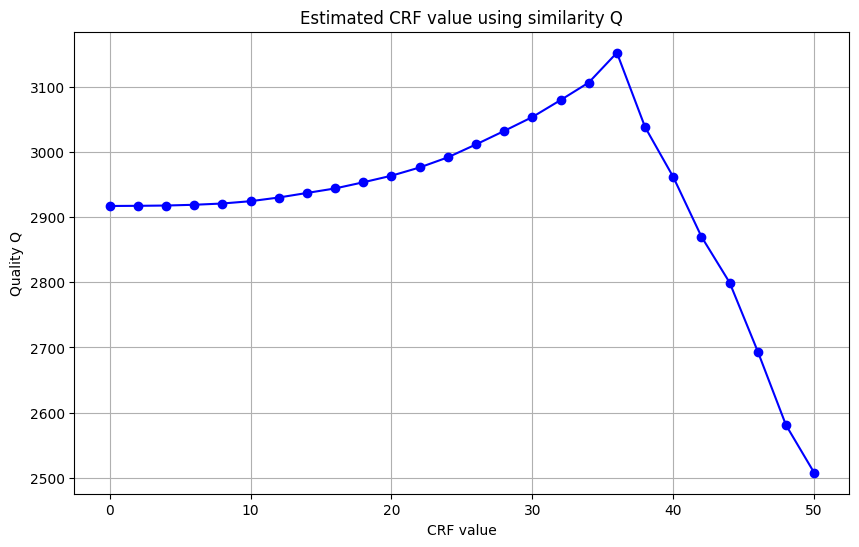

The estimated used CRF value was 36


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame from collected sim_values
df = pd.DataFrame(sim_values)

# Display  DataFrame
print(df)

# Plot CRF vs similarity Q values
plt.figure(figsize=(10,6))
plt.plot(df["crf"], df["sim"], marker='o', linestyle='-', color='blue')
plt.xlabel("CRF value")
plt.ylabel("Quality Q")
plt.title("Estimated CRF value using similarity Q")
plt.grid(True)
plt.show()

# selected CRF with maximum similarity Q
used_crf = df.loc[df["sim"].idxmax(), "crf"]

print(f"The estimated used CRF value was {used_crf}")


## Subtask 2: video encoding
Until now we assumed to have access to a well-developed and robust lossy video compression method.
However, in the following task, we will develop an "h.261" style video encoder.
From a general point of view, a lossy video encoder consists of two main steps:

* some frames are handled as full images and compressed using an image compression algorithm (I frames)
* other frames are predicted using the information preserved in the I frames, 
    usually, block-based motion compensation is used (P, B-frames, in the following only P frames are considered)


afterward, all frames are stored efficiently and compressed using arithmetic coding, Huffman encoding, or similar.
For this non-lossy compression part, we will use NumPy's zip functionality.

Thus we will mainly implement the I-frame and P-frame handling, which can be seen as fundamental building blocks of a hybrid video codec.

# Subtask 2.1: I-frame compression
Let's start with I frame compression.
Here we simplify the given problem by the following assumptions:

* we use $Y,C_b,C_r$ color space of the given video / image signal, no chroma sub-sampling is performed
* we implement a jpeg compression variant, assuming a fixed block size (in our example $(8,8)$), 
    advanced video codecs use variable block sizes with macro blocks and hierarchies 
* we only handle 8 bit images/videos
* we consider only a small resolution due to performance
* we use the same quantization matrix for all $Y,C_b, C_r$ channel planes

<img src="jpeg_style_comp.svg" alt="jpeg style compression" style="width:90%" >


We want to implement the following I frame compression algorithm for a given image $img$ with a quality level $quality\in[0,1]$:

* for each color plane in $Y,C_b,C_r$ space:
    * divide the given image into (8,8)-sized non overlapping blocks
    * for each block 
        * perform a DCT for the current block
        * quantize the DCT transformed image block $\leftarrow$ quantization matrix is given
        * round the quantized values and type cast them to integer
        * collect all transformed blocks 
    * collect transformed image plane 
* save the resulting compressed image using `np.savez_compressed(..)` as 'iframe.npz'


As before we will implement this step wise with some helper methods:

* `view_as_block` used to iterate over image with non overlapping blocks
* `dct_2d` 2D DCT
* `quantize_matrix` method to generate quantization matrices
* `encode_image_plane` compresses a single image plane
* `encode_image` encodes complete image
* `idct_2d` inverse 2D DCT
* `decode_image_plane` decodes image plane
* `decode_image` decodes image





In [10]:
def view_as_block(img, blocksize=(8,8)):
    """
    Yields non-overlapping blocks from the input image of size blocksize.
    Returns: i, j, block
    where i, j are the top-left coordinates of the block.
    """
    rows, cols = img.shape
    block_height, block_width = blocksize

    for i in range(0, rows, block_height):
        for j in range(0, cols, block_width):
            block = img[i:i+block_height, j:j+block_width]
            yield i, j, block


In [11]:
import numpy as np

def view_as_block(img, blocksize=(8,8)):
    """ this function returns views of the given image that have a defined blocksize """
    for i in range(0, img.shape[0], blocksize[0]):
        for j in range(0, img.shape[1], blocksize[1]):
            block = img[i:i+blocksize[0], j:j+blocksize[1]]
            yield i, j, block

dummy_image = np.array([
    [1,2,3,4],
    [5,6,7,8],
    [9,0,1,2],
    [3,4,5,6]
])

# Verification view_as_block function
for i, j, b in view_as_block(dummy_image, blocksize=(2,2)):
    print(i, j)
    print(b)
    print()

0 0
[[1 2]
 [5 6]]

0 2
[[3 4]
 [7 8]]

2 0
[[9 0]
 [3 4]]

2 2
[[1 2]
 [5 6]]



In [12]:
import numpy as np
from scipy.fftpack import dct

def dct_2d(block):
    """Perform a 2D DCT on the given block."""
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

# Check  the method works  expected
assert(dct_2d(np.array([[1,2],[2,3]]))[0,0].round(0) == 4)



In [13]:
import numpy as np

# Base quantization in matrix (luminance only)
base_Qm = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]
])

def quantize_matrix(quality):
    """Return a quantization matrix scaled by quality in [0,1]."""
    Q = int(quality * 100)
    S = 5000 / Q if Q < 50 else 200 - 2 * Q
    Qm = base_Qm.copy()
    Qm = np.floor((S * Qm + 50) / 100)
    Qm[Qm == 0] = 1  # avoid division by zero
    return Qm


In [14]:
import numpy as np
from scipy.fftpack import dct

# Base quantization matrix
base_Qm = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]
])

def quantize_matrix(quality):
    """Return a quantization matrix scaled by quality in [0,1]."""
    Q = int(quality * 100)
    S = 5000 / Q if Q < 50 else 200 - 2 * Q
    Qm = base_Qm.copy()
    Qm = np.floor((S * Qm + 50) / 100)
    Qm[Qm == 0] = 1  # avoid division by zero
    return Qm

def dct_2d(block):
    """2D DCT using scipy.fftpack.dct."""
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def view_as_block(img, blocksize=(8, 8)):
    """Yield blocks of the image of size blocksize."""
    for i in range(0, img.shape[0], blocksize[0]):
        for j in range(0, img.shape[1], blocksize[1]):
            block = img[i:i+blocksize[0], j:j+blocksize[1]]
            yield i, j, block

def encode_image_plane(image, quality):
    """Perform 2D DCT and quantization per block."""
    assert len(image.shape) == 2
    
    compressed_blocks = np.zeros_like(image, dtype=np.float32)
    Qm = quantize_matrix(quality)
    
    for i, j, b in view_as_block(image, (8, 8)):
        dct_block = dct_2d(b)
        quantized_block = np.round(dct_block / Qm).astype(int)  # Use int instead of np.int
        compressed_blocks[i:i+8, j:j+8] = quantized_block
        
    return compressed_blocks



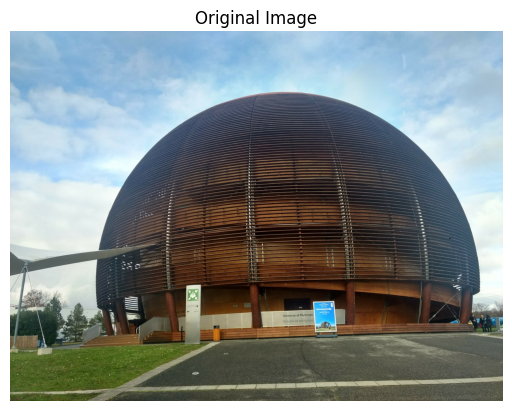

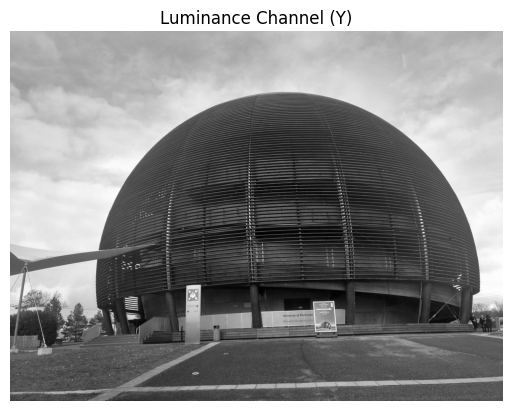

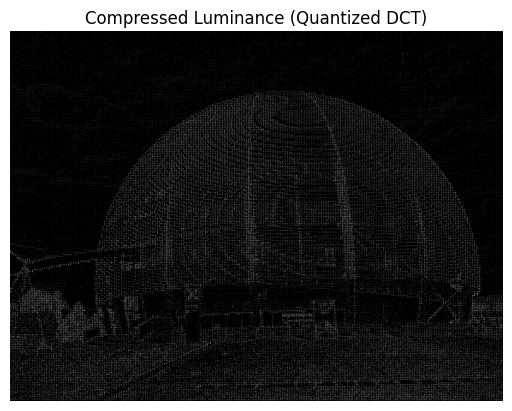

In [21]:
import numpy as np
import skimage.io
import skimage.color
from skimage.util import img_as_ubyte

import matplotlib.pyplot as plt

# ---  Show image ---
def show_image(img, title=""):
    """Show an image using matplotlib."""
    plt.imshow(img.astype(np.uint8), cmap='gray' if img.ndim == 2 else None)
    plt.title(title)
    plt.axis('off')
    plt.show()

# -------- Already defined elsewhere ---
# --------quantize_matrix
# -------- dct_2d
# -------- view_as_block
# -------- encode_image_plane

# --- Main function: encode image ---
def encode_image(img, compressed_filename=None, quality=0.5):
    # conversion to YCbCr
    ycbcr_image = skimage.color.rgb2ycbcr(img)
    
    # display of  luminance channel
    show_image(ycbcr_image[:, :, 0], title="Luminance Channel (Y)")

    compressed = np.zeros_like(ycbcr_image)
    
    # compress color channel
    for c in range(3):
        e = encode_image_plane(ycbcr_image[:, :, c], quality)
        compressed[:, :, c] = e

    # show compressed outcome
    show_image(compressed[:, :, 0], title="Compressed Luminance (Quantized DCT)")
    
    # conversion to int type for storage
    compressed = compressed.astype(int)

    if compressed_filename:
        np.savez_compressed(compressed_filename, img=compressed, quality=quality)
    
    return compressed

# --- Load compress an image ---
iimage = skimage.img_as_ubyte(skimage.io.imread("/Users/basharatnaeem/Documents/ts02 2/icomp.png"))
show_image(iimage, title="Original Image")

e = encode_image(iimage, "iframe.npz")


 as next we will handle the decoding part, this is more or less similar to encoding

In [24]:
from scipy.fftpack import idct

def idct_2d(block):
    """ perform a 2d inverse DCT for a given block """
    # Apply inverse DCT along both dimensions (first columns, then rows)
    return idct(idct(block.T, norm='ortho').T, norm='ortho')
# needed of a 2d inverse DCT
test_block = np.array([[1.0,2.0],[3.0,4.0]])
res = idct_2d(dct_2d(test_block))  # applying both dct and idct should end in an identity
assert((res.round(0) == test_block.round(0)).all())

In [25]:
def decode_image_plane(image, quality=1):
    """
    Perform inverse 2d DCT to each image block after dequantization, and decode compressed image
    """
    assert(len(image.shape) == 2)
    decomp = np.zeros(image.shape)
    Qm = quantize_matrix(quality)
    
    for i, j, b in view_as_block(image, (8,8)):
        # Dequantize block by multiplying with quantization matrix
        dequantized_block = b * Qm
        # Apply inverse DCT to the dequantized block
        idct_block = idct_2d(dequantized_block)
        # Store decoded block back to decomp
        decomp[i:i+8, j:j+8] = idct_block
    
    return decomp


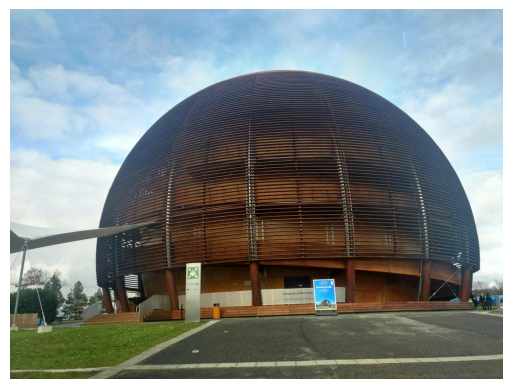

In [26]:
def decode_image(compressed_filename):
    """ Decodes an image using the developed method """
    # Loading compressed image and quality level
    file_content = np.load(compressed_filename)
    compressed = file_content["img"]
    quality = file_content["quality"].item()  # make sure to get scalar quality

    # Initialize decompressed image array with zeros, same shape  compressed
    decompressed = np.zeros_like(compressed, dtype=np.float32)

    # Iterate over color planes assuming 3 channels
    for c in range(compressed.shape[2]):
        # Decode each color plane using decode_image_plane
        d = decode_image_plane(compressed[:, :, c], quality)
        # Store decoded results decompressed array
        decompressed[:, :, c] = d

    # Convert back from YCbCr to RGB, clip to valid range [0,1], then scale to [0,255] uint8
    rgb_image = np.clip(skimage.color.ycbcr2rgb(decompressed), 0, 1) * 255
    return rgb_image.astype(np.uint8)


# Use
dimage = decode_image("iframe.npz")
show_image(dimage)
skimage.io.imsave("dimage.png", dimage)

In [27]:
import os

# Path the files
png_path = "dimage.png"
npz_path = "iframe.npz"

# Get file sizes  bytes
png_size_bytes = os.path.getsize(png_path)
npz_size_bytes = os.path.getsize(npz_path)

# Convert bytes tooo kilobytes (KB)
png_size_kb = png_size_bytes / 1024
npz_size_kb = npz_size_bytes / 1024

print("png", png_size_kb, "KB")
print("npz", npz_size_kb, "KB")


png 3599.4541015625 KB
npz 1112.77734375 KB


## Subtask 2.2: motion estimation
In the following cells, we will implement a simple motion estimation approach to make our developed video codec complete.
We will implement a simple variant of block-based motion estimation.
This allows us to reuse some of our previously implemented helper methods.

Check out the following:
* https://en.wikipedia.org/wiki/Block-matching_algorithm
* http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.736.5057&rep=rep1&type=pdf


<img src="block_matching.svg" alt="block matching" style="width:60%" >


In the following we assume:
* block matching is performed only on luminance channel, if two blocks are matching in luminance we take over their corresponding chrominance channels
* our block matching search is performed on the uncompressed video frames
* we only care about P frames, they only consider the previous frame in their motion estimation
* we implement exhaustive block matching search with max_distance and a blocksize of (8,8)
    * thus for a block at image position $i,j$, we check all blocks in the previouse frame in range $[i-max\_distance, i + max\_distance]$ and analog for $j$
    * important the range matches the image boundaries



In [28]:
def search_range(i, max_i, max_distance, blocksize):
    """ helper function to create an range iterator 
        for a specific coordinate i and max_i, maxdistance, and the blocksize,
        
        search_range ensures that only parts inside the 1D array boundaries are handled.
    """
    min_range = max(i - max_distance, 0)
    max_range = min(i + max_distance + 1, max_i - blocksize + 1)  # +1 because range end is exclusive
    return range(min_range, max_range)


print(
    list(search_range(2, 10, 3, 2)),
    list(search_range(0, 10, 3, 2)),
    list(search_range(5, 10, 3, 2)),
    list(search_range(9, 10, 3, 2))
)

assert(list(search_range(2, 10, 3, 2)) == [0, 1, 2, 3, 4, 5])
assert(list(search_range(0, 10, 3, 2)) == [0, 1, 2, 3])
assert(list(search_range(5, 10, 3, 2)) == [2, 3, 4, 5, 6, 7, 8])
assert(list(search_range(9, 10, 3, 2)) == [6, 7, 8])


[0, 1, 2, 3, 4, 5] [0, 1, 2, 3] [2, 3, 4, 5, 6, 7, 8] [6, 7, 8]


In [29]:
import numpy as np

def exhaustive_search(prev, curr, blocksize=(8,8), max_distance=10):
    """
    performs an exhaustive block matching search with a blocksize of `blocksize`
    here a maximum distance of `max_distance` pixels is assumed, as error measure we use our implemented
    psnr_image, a block matches if it has either np.inf as psnr value or we take the block with max psnr out of
    all analyzed blocks
    """
    motion_vectors = np.zeros([curr.shape[0] // blocksize[0], curr.shape[1] // blocksize[1], 2], dtype=np.int)
    # motion_vectors stores the displacement vectors per block
    
    for i, j, b in view_as_block(curr, blocksize=blocksize):
        # estimate block indices in motion vector grid
        bi = i // blocksize[0]
        bj = j // blocksize[1]
        
        block_results = []
        equal_found = False
        
        # Exhaustive search in prev frame over  defined search range
        for ti in search_range(i, prev.shape[0], max_distance, blocksize[0]):
            for tj in search_range(j, prev.shape[1], max_distance, blocksize[1]):
                block_to_check = prev[ti:ti+blocksize[0], tj:tj+blocksize[1]]
                
                # Calculate PSNR similarity b/w blocks
                sim = psnr_image(b, block_to_check)
                
                block_results.append((ti, tj, sim))
                
                if sim == np.inf:  # Perfect match found, break early
                    equal_found = True
                    break
            if equal_found:
                break
        
        # Select  best matching block (max PSNR)
        ti, tj, sim = max(block_results, key=lambda x: x[2])
        
        # Store displacement (shift) vector relative to current block position
        motion_vectors[bi, bj, 0] = ti - i  # vertical displacement
        motion_vectors[bi, bj, 1] = tj - j  # horizontal displacement
        
    return motion_vectors

#  usage with your small example blocks:

def psnr_image(a, b):
    """ Simple PSNR calculation between two blocks """
    mse = np.mean((a - b) ** 2)
    if mse == 0:
        return np.inf
    PIXEL_MAX = 255.0  # assuming 8-bit images, adapt if needed
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

def view_as_block(img, blocksize=(8,8)):
    for i in range(0, img.shape[0], blocksize[0]):
        for j in range(0, img.shape[1], blocksize[1]):
            yield i, j, img[i:i+blocksize[0], j:j+blocksize[1]]

def search_range(i, max_i, max_distance, blocksize):
    min_range = max(i - max_distance, 0)
    max_range = min(i + max_distance + 1, max_i - blocksize + 1)
    return range(min_range, max_range)

prev_example = np.array([
    [1,2,3,4],
    [1,2,3,4],
    [1,2,3,4],
    [1,2,3,4]
])

curr_example = np.array([
    [0,1,2,3],
    [0,1,2,3],
    [0,1,2,3],
    [0,1,2,3]
])

print(exhaustive_search(prev_example, curr_example, blocksize=(2,2), max_distance=2))


[[[ 0  0]
  [ 0 -1]]

 [[-2  0]
  [-2 -1]]]


In [31]:
import numpy as np
import skimage.color
import skimage.io
import glob
import os

def predict_frame(prev, motion_vectors, blocksize=(8,8)):
    """
    Using the estimated motion vectors, this function predicts the next frame based on the previous.

    prev is a colored image (H x W x 3).
    motion_vectors has shape (H/blocksize[0], W/blocksize[1], 2) with vertical and horizontal displacements.
    """
    pred = np.zeros_like(prev)
    h_blocks, w_blocks = motion_vectors.shape[:2]
    
    for i in range(h_blocks):
        for j in range(w_blocks):
            # Calculate pixel coordinates of current block in the predicted frame
            y = i * blocksize[0]
            x = j * blocksize[1]

            # Get  motion vector for this block (dy, dx)
            dy, dx = motion_vectors[i, j]

            # Calculate corresponding source block in the previous frame
            src_y = y + dy
            src_x = x + dx

            # Boundary check to avoid indexing errors
            src_y = max(0, min(src_y, prev.shape[0] - blocksize[0]))
            src_x = max(0, min(src_x, prev.shape[1] - blocksize[1]))

            # Copy the block from the previous frame according to motion vector
            pred[y:y+blocksize[0], x:x+blocksize[1]] = prev[src_y:src_y+blocksize[0], src_x:src_x+blocksize[1]]

    return pred.astype(np.uint8)


# Example usage for a video sequence:
os.makedirs("pframe", exist_ok=True)

frames = sorted(glob.glob("frames/*"))
i = 1
for prev_path, curr_path in zip(frames[0:-1], frames[1:]):
    prev = skimage.io.imread(prev_path)
    curr = skimage.io.imread(curr_path)
    
    # Extract luminance channels (Y) fom both frames
    prev_y = skimage.color.rgb2ycbcr(prev)[:, :, 0]
    curr_y = skimage.color.rgb2ycbcr(curr)[:, :, 0]
    
    # Compute motion vectors using exhaustive search luminance
    motion_vectors = exhaustive_search(prev_y, curr_y, blocksize=(8,8), max_distance=10)
    
    # Predict next frame using motion vectors on full color frame
    predicted_frame = predict_frame(prev, motion_vectors, blocksize=(8,8))
    
    # Save predicted frame
    skimage.io.imsave(f"pframe/{str(i).zfill(3)}.png", predicted_frame)
    
    #  visual check
    show_image(predicted_frame)

    i += 1


